In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

epoch=10000 loss=0.13052363464261982
epoch=10000 accu=0.97


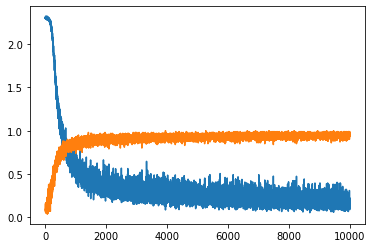

CPU times: user 1min 16s, sys: 33.6 s, total: 1min 49s
Wall time: 32.3 s


In [3]:
%%time
from common.functions import softmax, sigmoid, cross_entropy_error
#network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

class NN():
    def __init__(self, input_size, hidden_size, output_size):
        W1 = 0.01 * np.random.randn(input_size, hidden_size)
        b1 = np.zeros(hidden_size)
        W2 = 0.01 * np.random.randn(hidden_size, output_size)
        b2 = np.zeros(output_size)
        self.W1, self.b1, self.W2, self.b2 = W1, b1, W2, b2

    def predict(self, x):
        W1, b1, W2, b2 = self.W1, self.b1, self.W2, self.b2
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        self.x, self.a1, self.z1, self.a2 = x, a1, z1, a2
        return a2
        
    def forward(self, x, t):
        a2 = self.predict(x)
        y = softmax(a2)
        loss = cross_entropy_error(y, t)
        accuracy = (t.argmax(axis=1)==y.argmax(axis=1)).sum() / len(t)
        self.y, self.t = y, t
        return loss, accuracy
    
    def backward(self):
        W1, b1, W2, b2 = self.W1, self.b1, self.W2, self.b2
        x, a1, z1, a2 = self.x, self.a1, self.z1, self.a2
        y, t = self.y, self.t
        
        # SoftmaxWithSigma
        dout = (y - t) / len(t)

        # Affine 2
        dx = np.dot(dout, W2.T)
        dW2 = np.dot(z1.T, dout)
        db2 = np.sum(dout, axis=0)
        dout = dx

        # Sigmoid
        dout = dout * (1.0 - z1) * z1 

        # Affine 1
        dx = np.dot(dout, W1.T)
        dW1 = np.dot(x.T, dout)
        db1 = np.sum(dout, axis=0)
        
        self.dW1, self.db1, self.dW2, self.db2 = dW1, db1, dW2, db2        
    
    def update(self, lr):
        self.W1 -= lr * self.dW1
        self.b1 -= lr * self.db1
        self.W2 -= lr * self.dW2
        self.b2 -= lr * self.db2
        
    
    
nn = NN(len(x_train[0]), hidden_size=50, output_size=len(t_train[0]))

iters_num = 10000  # 繰り返しの回数を適宜設定すaる
train_size = x_train.shape[0]
batch_size = 100
lr = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

# Train NN
loss_list, accu_list = [], []
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    xx = x_train[batch_mask]
    tt = t_train[batch_mask]
    
    l, a = nn.forward(xx, tt)
    loss_list.append(l)
    accu_list.append(a)

    nn.backward()
    nn.update(lr)
    
#Plot accuracy over time    
print(f"epoch={len(loss_list)} loss={loss_list[-1]}")
print(f"epoch={len(loss_list)} accu={accu_list[-1]}")
plt.plot(range(len(loss_list)), loss_list)
plt.plot(range(len(accu_list)), accu_list)
plt.show()